# Hybrid Quantum Convolutional Neural Networks

In this notebook we introduce the hybrid quantum-classical 3D CNN, which is designed to reduce the complexity of the classical 3D CNN, while maintaining its prediction performance. The hybrid CNN replaces a convolutional layer with a quantum convolutional layer. That is, each classical convolutional filter is replaced by a quantum circuit, which acts as a quantum filter. Each quantum circuit is divided into two blocks: the *data encoding*, which maps the input data into a quantum circuit, and the *quantum transformation*, where quantum operations are applied to retrieve information from the encoded data.

We provide an implementation of this algorithm on Qiskit, which is meant to run on real hardware or fake simulators. We also provide an implementation with Pytorch, which is optimized to work faster in quantum simulation (CPUs and GPUs).

## Data encoding: Flexible Representation of Quantum Images

The first step is to encode the classical 3D image into a quantum circuit. The image is too big to fit on a quantum circuit, and we want to extract local features from the image to mimic what convolutional layers do. For this reason, we partition the images in (nxnxn) blocks, and fit each of these blocks in a quantum circuit. The encoding is called *Flexible Representation of Quantum Images*.

This encoding consists of using the first qubit to encode the pixel value, and the others to encode the position of such pixel. 

$$
\renewcommand{\ket}[1]{\left|{#1}\right\rangle}
\renewcommand{\bra}[1]{\left\langle{#1}\right|}
\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\ket{I(\theta)}=\frac{1}{2^{n} }\sum_{i=0}^{2^{2n}-1}\left(\cos \theta_{i}\ket{0}+\sin\theta_{i}\ket{1}\right)\otimes\ket{i}
$$

where the angles have been normalized between $[0, \pi/2]$.  For example, take the 2x2 image

$$
\begin{array}{|c|c|}
\hline
\theta_{0},(00) & \theta_{1},(01)  \\
\hline
\theta_{2},(10) & \theta_{3},(11) \\
\hline
\end{array}
$$

The quantum state encoding this image is

$$
\begin{aligned}
\ket{I}=\frac{1}{2}[ \; & \phantom{+} \left(\cos\theta_{0}\ket{0}+\sin\theta_{0}\ket{1} \right)\otimes\ket{00}&\\
& + \left(\cos\theta_{1}\ket{0}+\sin\theta_{1}\ket{1} \right)\otimes\ket{01} \\
& + \left(\cos\theta_{2}\ket{0}+\sin\theta_{2}\ket{1} \right)\otimes\ket{10}\\
& + \left(\cos\theta_{3}\ket{0}+\sin\theta_{3}\ket{1} \right)\otimes\ket{11} \;]
\end{aligned}
$$

## Quantum transformation

he use of quantum reservoirs (QR) is an emerging approach in quantum machine learning (QML), which has provided promising results in multiple tasks. It exploits the quantumness of a physical system to extract useful properties of the data that are then used to feed a machine learning model. In gate-based quantum computation, a QR is a *random* quantum circuit applied to an initial state, which encodes the input data, followed by measurements of local operators. These measurements are the features extracted by the model, which are then fed to a classical machine learning algorithm to predict the desired output. The main advantage of using QRs is the low complexity of the model, and thus, its easy training strategy. Instead of using parametrized quantum circuits and finding its optimal parameters, QRs use carefully selected quantum systems with no training parameters to transform the input data. These quantum filters consist of random quantum circuits, selected from a given family, with a fixed number of gates. The number of gates and the family of gates can be chosen by the user. We propose to use the following family of gates:

$$
G_3 = \{H, CNOT, T\}
$$

which has proven to provide optimal results in quantum machine learning (see https://journals.aps.org/pre/abstract/10.1103/PhysRevE.106.L043301). However, other families can be tested. Other implemented families are

$$
G1 = \{CNOT, H, X\}
$$

$$
G2 = \{CNOT, H, S\}
$$

and the transverse-field Ising model, where the system is evolved under the evolution of the following Hamiltonian:

$$
H_{\text{Ising}} = \sum_{i,j=0}^{N-1} J_{ij} Z_iZ_j + \sum_{i}^{N-1} h_{i} X_i,
$$
where $X_i$ and $Z_j$ are Pauli operators acting on the site $i, j$-th qubit.

In [1]:
import matplotlib.pyplot as plt
from time import time
from torch import device, nn, zeros
from torch.utils.data import DataLoader
import numpy as np

from data.data_reader import Dataset_MLHDF
from data.img_util import GaussianFilter, Voxelizer3D
from ingenii_quantum.hybrid_networks.filters import QuantumFilters3D

## Loading the data

We load 5 samples of the Core set from the PDBBind dataset. Then, we visualize one example of the data.

In [2]:
from importlib.resources import files

# Access the data folder
data_folder = files("ingenii_quantum.data")

dataset = Dataset_MLHDF(
    data_folder / 'pdbbind2016_core_test.hdf', 1, data_folder /'data/pdbbind2016_core_test_3dnn.csv',
    is_crystal=True, rmsd_weight=0, rmsd_thres=2
)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=True)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

torch_device = device("cpu")
vol_batch = zeros((5,19,48,48,48)).float().to(torch_device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)
    break

C:\Users\laiad\AppData\Roaming\Python\Python311\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


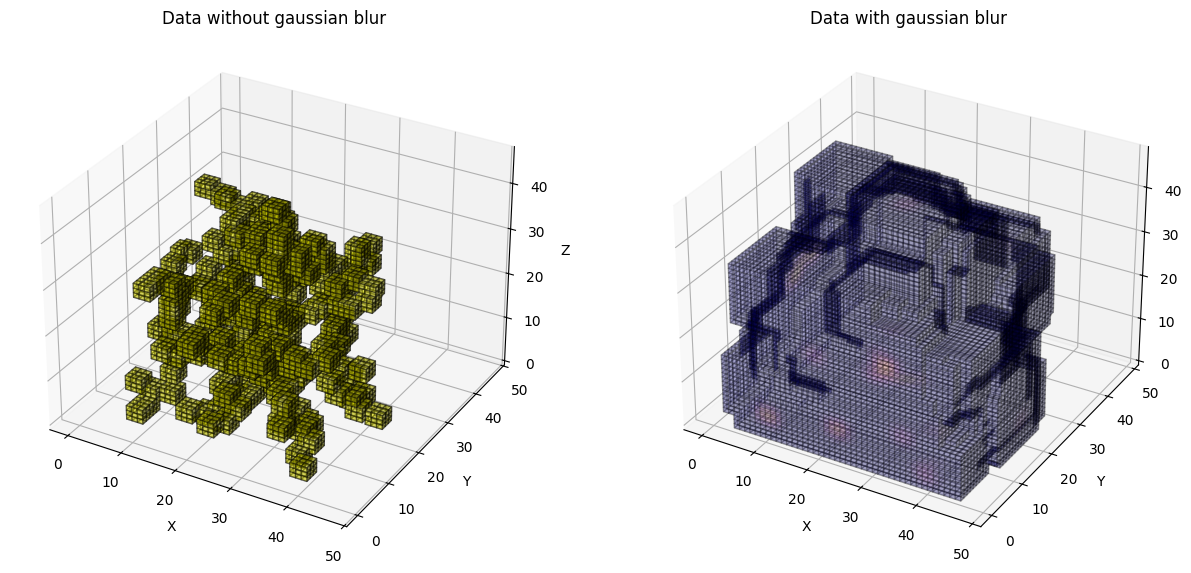

In [3]:
d2 = vol_batch_gaus[0][1].numpy()
d = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.voxels(d,facecolors='yellow', alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Data without gaussian blur')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Data with gaussian blur')

plt.show()

## Example 3D Quantum filter

Now we visualize an example of a 3D quantum filter, generated from the G3 family of gates. The quantum reservoirs contain 300 gates. Each data sample is separated in blocks of size n=4 and stride 1. We run this example first in the Pytoch backend and then in some Qiskit backends (aer_simulator and fake backend) and compare the execution times.

First we store the unitaries in a file, so that we can use them later.

In [4]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), encoding='frqi', stride=1, backend='torch')

quantum_filters_3D.generate_reservoirs(
    gates_name='G3', num_gates=50, num_filters=2, num_features=19,
    save=True, filename='unitaries.pickle'
)

In [5]:
start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus, tol=1e-6)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print('Output shape = ', result.shape)
print(f'Execution time with Pytorch backend: {str(minutes)} mins {str(seconds)} seconds')

c:\users\laiad\ingenii, inc\ingenii llc - documents\research\library\ingenii-quantum\v0.0.1\ingenii_quantum\hybrid_networks\filters.py:1003: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data) if self.backend=='torch' else np.array(data)


Output shape =  torch.Size([5, 38, 48, 48, 48])
Execution time with Pytorch backend: 0.0 mins 5.0 seconds


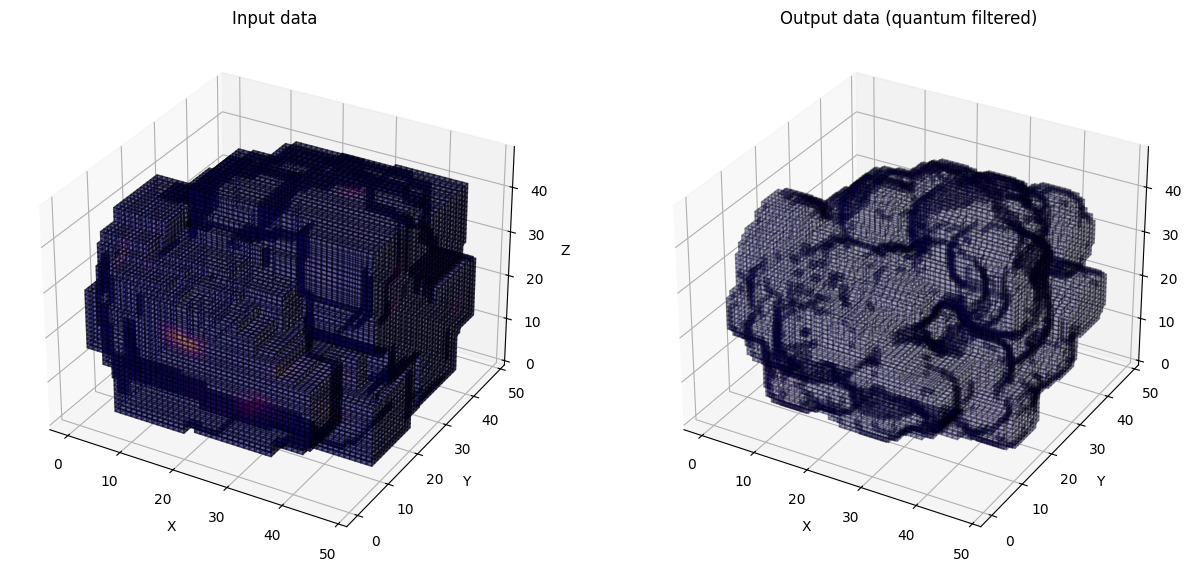

In [6]:
d = vol_batch_gaus[0,1]
d2 = result[0,1]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Loading the unitaries

Here we show an example loading the unitaries from the pickle file and running the script again.

In [6]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), encoding='frqi', stride=1, backend='torch')

quantum_filters_3D.load_reservoirs(filename='unitaries.pickle')

In [7]:
start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus, tol=1e-6)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print('Output shape = ', result.shape)
print(f'Execution time with Pytorch backend: {str(minutes)} mins {str(seconds)} seconds')

c:\users\laiad\ingenii, inc\ingenii llc - documents\research\library\ingenii-quantum\v0.0.1\ingenii_quantum\hybrid_networks\filters.py:1003: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data) if self.backend=='torch' else np.array(data)


Output shape =  torch.Size([5, 38, 48, 48, 48])
Execution time with Pytorch backend: 0.0 mins 5.0 seconds


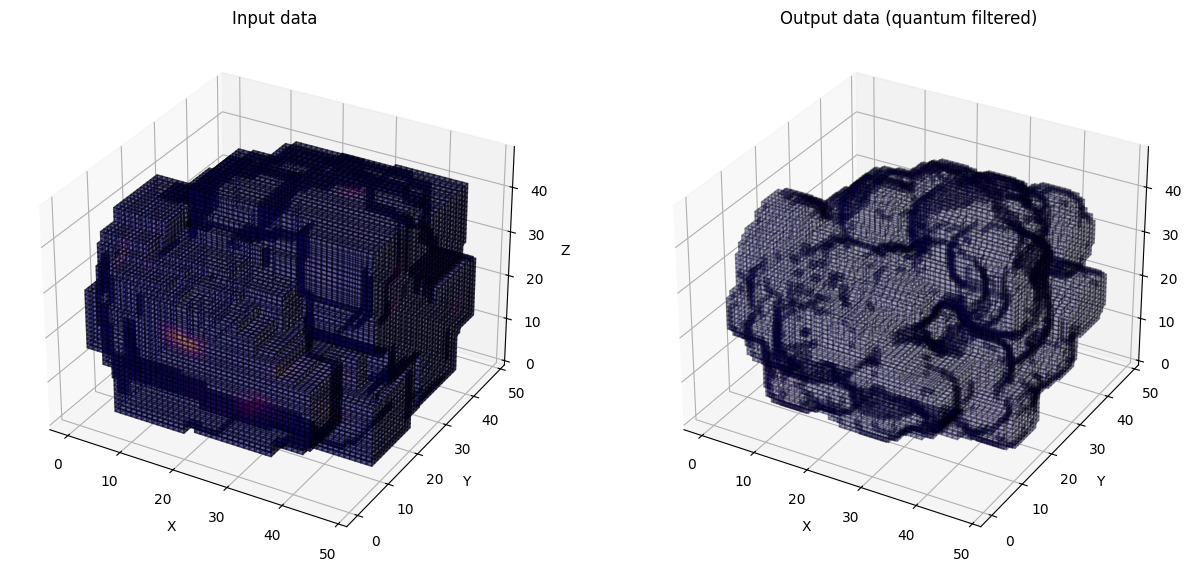

In [9]:
d = vol_batch_gaus[0,1]
d2 = result[0,1]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Running with Qiskit simulator



In [8]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), encoding='frqi', shots=16, backend ='aer_simulator', stride=1)

quantum_filters_3D.generate_reservoirs(
    gates_name='G3',num_gates=50, num_filters=2, num_features=19, save=True,
    filename='reservoir_3D.pickle')

In [ ]:
# Note: this will take approx. 40 minutes

start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus.numpy().copy(), tol=1e-4)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print('Output shape = ', result.shape)
print(f'Execution time with Qiskit quantum simulation: {str(minutes)} mins {str(seconds)} seconds')

We see that running the code with quantum simulation using Qiskit is much slower than using Pytorch. Also, the results highly depend on the number of shots (the larger the better). With a very small number of shots we see that the outputs are significantly different.

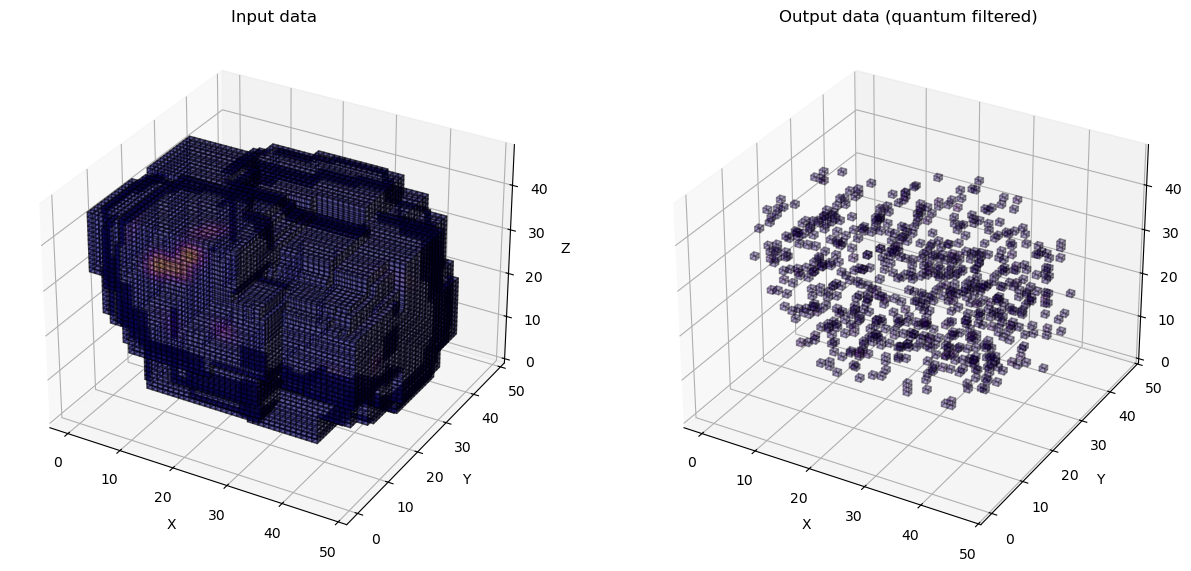

In [12]:
d = vol_batch_gaus[0,1]
d2 = result[0,1]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Running with Qiskit fake provider

Finally, we can run the code with a fake provider (or actual hardware if you have access to it) using Qiskit. We use bigger (nxn) blocks so that the execution is faster.

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
 
# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')
 
# generate a simulator that mimics the real quantum system with the latest calibration results
fake = AerSimulator.from_backend(backend)

In [11]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), shots=16, backend=fake, stride=2)

# Run to load the quantum circuits
#quantum_filters_3D.load_reservoirs(filename='reservoir_3D.pickle')
quantum_filters_3D.generate_reservoirs(gates_name='G3', num_gates=50, num_filters=2, num_features=19, save=False)

In [ ]:
# Note: this will take approx. 2 hours

start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus[:1,:,:,:,:].numpy().copy(), tol=1e-4)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print(f'Execution time with Qiskit fake provider: {str(minutes)} mins {str(seconds)} seconds')

In [ ]:
d = vol_batch_gaus[0, 1]
d2 = result[0, 1]

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d, facecolors=colors, alpha=0.4, edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2, facecolors=colors, alpha=0.2, edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Hybrid neural network: input layer

Here we show an example of a hybrid quantum classical convolutional neural network, where the quantum filters are applied to the original data, and combined with the output of a classical convolutional layer. In this case, the quantum filters are used as a pre-processing step, and can be calculated to the whole dataset before the training of the model. 

<center>
<img src="images/HybridCNN.png" width=800 />
</center>

### 1. Calculate the quantum filters

In [12]:
# Original data
data = vol_batch_gaus

# Output of the quantum filters
quantum_filters_3D = QuantumFilters3D(shape=(4,4,4), stride=1)
quantum_filters_3D.generate_reservoirs(
    gates_name='G3', num_gates=500, num_filters=3, num_features=19, save=False
)
data_QF = quantum_filters_3D.get_quantum_filters(data, tol=1e-6)

c:\users\laiad\ingenii, inc\ingenii llc - documents\research\library\ingenii-quantum\v0.0.1\ingenii_quantum\hybrid_networks\filters.py:1003: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data) if self.backend=='torch' else np.array(data)


### 2. Define the classical CNN that uses both the original data and the quantum filters

In [13]:
class ModelHybrid1(nn.Module):

    # num_filters=[64,128,256] or [96,128,128]
    def __init__(self, feat_dim=19, num_filters=[57,128,256], use_cuda=True, verbose=False):
        super(ModelHybrid1, self).__init__()
        
        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.verbose = verbose

        self.conv1 = nn.Conv3d(feat_dim, num_filters[0], 7, 1, 3)
        self.bn1 = nn.BatchNorm3d(num_filters[0])
        
        self.conv2 = nn.Conv3d(num_filters[0], self.num_filters[1], 7, 3, 3)
        self.bn2 = nn.BatchNorm3d(self.num_filters[1])
        self.max_pool1 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(self.num_filters[1], self.num_filters[2], 5, 2, 2)
        self.bn3 = nn.BatchNorm3d(self.num_filters[2])
        self.max_pool2 = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(16384, 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()


    def forward(self, x, x_quantum):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        if x_quantum.dim() == 1:
            x_quantum = x_quantum.unsqueeze(-1)
        if self.verbose:
            print('Input', list(x.size()), ' Input quantum', list(x_quantum.size()))
        
        conv1= self.conv1(x)
        if self.verbose:
            print('Conv1 (7x7x7)', list(conv1.shape))

        conv1_res1 = x_quantum + conv1
        if self.verbose:
            print('Conv1 + Quantum', list(conv1_res1.shape))

        conv2 = self.conv2(conv1_res1)
        conv2 = self.bn2(self.relu(conv2))
        if self.verbose:
            print('Conv2 (7x7x7)', list(conv2.shape))
        
        pool1 = self.max_pool1(conv2)
        if self.verbose:
            print('Pooling 1', list(pool1.shape))
            
        conv3 = self.conv3(conv2)
        conv3 = self.bn3(self.relu(conv3))
        if self.verbose:
            print('Conv 3 (7x7x7)',list(conv3.shape))

        pool2 = self.max_pool2(conv3)
        if self.verbose:
            print('Pooling 2', list(pool2.shape))

        flatten = pool2.view(pool2.size(0), -1)
        if self.verbose:
            print('Flatten', list(flatten.shape))

        fc1 = self.fc1(flatten)
        fc1 = self.relu(fc1)
        if self.verbose:
            print('Fc1', list(fc1.shape))

        fc2 = self.fc2(fc1)
        if self.verbose:
            print('Fc2', list(fc2.shape))

        return fc2

In [14]:
model = ModelHybrid1(use_cuda=False, verbose=True)

In [15]:
ypred_batch= model(data, data_QF)

Input [5, 19, 48, 48, 48]  Input quantum [5, 57, 48, 48, 48]
Conv1 (7x7x7) [5, 57, 48, 48, 48]
Conv1 + Quantum [5, 57, 48, 48, 48]
Conv2 (7x7x7) [5, 128, 16, 16, 16]
Pooling 1 [5, 128, 8, 8, 8]
Conv 3 (7x7x7) [5, 256, 8, 8, 8]
Pooling 2 [5, 256, 4, 4, 4]
Flatten [5, 16384]
Fc1 [5, 10]
Fc2 [5, 1]


## Hybrid neural network: convolutional layer

Instead of using the quantum layer as a pre-processing step, we can use the quantum filter as a layer of the network. For this, we need to use the *QuantumLayer3D* function.

<center>
<img src="images/HybridCNN2.png" width=800 />
</center>

In [16]:
# Original data (no need to apply the quantum filters now)
data = vol_batch_gaus

In [17]:
class ModelHybrid2(nn.Module):

    def __init__(self, feat_dim=19, num_filters=[64,64,128], use_cuda=True, verbose=False,
                 shape=(4,4,4), num_filters_q=1, gates_name='G3', num_gates=300, tol=1e-6,stride=2,
                 load_unitaries_file_name=None, filename='unitaries.pickle'):
        super(ModelHybrid2, self).__init__()
        
        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.use_cuda = use_cuda
        self.verbose = verbose

        self.quantumlayer = QuantumFilters3D(
            shape=shape,stride=stride
        )
        if load_unitaries_file_name:
            self.quantumlayer.load_reservoirs(filename=filename)
        else:
            self.quantumlayer.generate_reservoirs(gates_name=gates_name, num_gates=num_gates, num_filters=num_filters_q, num_features=num_filters[0], save=True)
    
        self.conv1 = nn.Conv3d(feat_dim, num_filters[0], 7, 1, 3)
        self.bn1 = nn.BatchNorm3d(num_filters[0])
        
        self.conv2 = nn.Conv3d(num_filters[0], self.num_filters[1], 7, 2, 3)
        self.bn2 = nn.BatchNorm3d(self.num_filters[1])
        self.max_pool1 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(self.num_filters[1], self.num_filters[2], 5, 2, 2)
        self.bn3 = nn.BatchNorm3d(self.num_filters[2])
        self.max_pool2 = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(27648, 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()


    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        if self.verbose:
            print('Input', list(x.size()))
        
        conv1 = self.conv1(x)
        conv1 = self.bn1(self.relu(conv1))
        if self.verbose:
            print('Conv1 (7x7x7)', list(conv1.shape))

        conv2 = self.conv2(conv1)
        conv2 = self.bn2(self.relu(conv2))
        if self.verbose:
            print('Conv2 (7x7x7)', list(conv2.shape))
        
        quantum_conv = self.quantumlayer.get_quantum_filters(conv2)     
        if self.verbose:
            print('Quantum filter ', list(quantum_conv.shape))
            
        conv2_quantum = conv2 + quantum_conv
        if self.verbose:
            print('Conv2 + Quantum filter ', list(conv2_quantum.shape))
            
        pool1 = self.max_pool1(conv2_quantum)
        if self.verbose:
            print('Pooling 1', list(pool1.shape))
            
        conv3 = self.conv3(conv2)
        conv3 = self.bn3(self.relu(conv3))
        if self.verbose:
            print('Conv 3 (7x7x7)',list(conv3.shape))

        pool2 = self.max_pool2(conv3)
        if self.verbose:
            print('Pooling 2', list(pool2.shape))

        flatten = pool2.view(pool2.size(0), -1)
        if self.verbose:
            print('Flatten', list(flatten.shape))

        fc1 = self.fc1(flatten)
        fc1 = self.relu(fc1)
        if self.verbose:
            print('Fc1', list(fc1.shape))

        fc2 = self.fc2(fc1)
        if self.verbose:
            print('Fc2', list(fc2.shape))

        return fc2

In [18]:
model = ModelHybrid2(use_cuda=False, verbose=True, stride=1, shape=(2,2,2))

In [19]:
ypred_batch = model(data)

Input [5, 19, 48, 48, 48]
Conv1 (7x7x7) [5, 64, 48, 48, 48]
Conv2 (7x7x7) [5, 64, 24, 24, 24]


c:\users\laiad\ingenii, inc\ingenii llc - documents\research\library\ingenii-quantum\v0.0.1\ingenii_quantum\hybrid_networks\filters.py:1003: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data) if self.backend=='torch' else np.array(data)


Quantum filter  [5, 64, 24, 24, 24]
Conv2 + Quantum filter  [5, 64, 24, 24, 24]
Pooling 1 [5, 64, 12, 12, 12]
Conv 3 (7x7x7) [5, 128, 12, 12, 12]
Pooling 2 [5, 128, 6, 6, 6]
Flatten [5, 27648]
Fc1 [5, 10]
Fc2 [5, 1]
